In [1]:
import numpy as np
%matplotlib
import matplotlib.pyplot as plt
from hello.pid.lvpid import PIDController
from hello.pid.delay import m2s, s2m, h2s, seconds, minutes, hours, days, DelayBuffer, DelaySink
from matplotlib.ticker import MultipleLocator, FuncFormatter, FormatStrFormatter
from hello.pid.picker import mk_picker

Using matplotlib backend: TkAgg


In [2]:
from decimal import Decimal as D
import math
class DelaySink():
    def __init__(self, delay, initial, pc_decay=0.95, scalar=1):
        assert 0 < pc_decay <= 1, "don't be a retard"
        self.df1 = self.calc_df(delay, pc_decay)
        self._delay = delay
        self._pc = pc_decay
        self.df2 = scalar*self.df1
        self.dft = self.df1 + self.df2
        self.dff1 = self.df1 / self.dft
        self.dff2 = self.df2 / self.dft
        self.fill_sink(initial)
        
    def fill_sink(self, value):
        if self._delay:
            self.sink = value * (1-self.df1) / self.df1
        else:
            self.sink = 0
        
    def calc_df(self, delay, pc):
        if not delay:
            return 1
        # Attempt to be precise by temporarily using decimal.Decimal
        one = D(1)
        return float(one - (one - D(pc))**(one / D(delay)))
        
    def set_delay(self, delay):
        self.df = self.calc_df(delay, self._pc)
        self._delay = delay
        
    def delay(self, v):
        """ Delay the value v and advance the decay model by 1 second.
        Add v to the current sink, then allow the sink to decay
        according to the decay factor. 
        
        The total decay is given by sink * (df1 + df2). The value
        returned to the system is given by sink * df1. The amount
        lost (e.g., due to radiative heat losses) is given by 
        sink * df2. 
        
        """
        self.sink += v
        ds = self.sink*(self.df1 + self.df2)
        d1 = ds * self.dff1
        d2 = ds * self.dff2
        self.sink -= ds
        if self.sink < 0:
            self.sink = 0
        return d1
    
class DelaySink2(DelaySink):
    def calc_df(self, delay, pc):
        if not delay:
            return 1
        return 1-math.e**(math.log(1-pc)/delay)
    def fill_sink(self, value):
        if self._delay:
            self.sink = (1-self.df1)*value/self.df1
        else:
            self.sink = 0
        

In [3]:
class TempProcess():
    def __init__(self, delay, initial=20, output=0, env=18.5, g=0.0019254, k=-0.001579031, g_mult=1):
        """
        :param g: gain in units of C/min/%
        :param k: decay rate in units of C/min/dT
        """
        self.tdelay = DelayBuffer(delay, initial).cycle
        self.g = g / 60
        self.k = k / 60
        self.env = env
        self.pv = initial
        
    def step(self, op):
        op = self.tdelay(op)
        dT = self.pv - self.env
        decay = self.k * dT
        gain = self.g * op
        dpv = decay + gain
        self.pv += dpv
        return self.pv
    
class TempProcess2():
    def __init__(self, delay, initial=20, output=0, env=18.5, g=0.0019254, k=-0.001579031, decay=1):
        """
        :param g: gain in units of C/min/%
        :param k: decay rate in units of C/min/dT
        """
        self.heatsink = DelaySink(delay, output, 0.95, decay)
        self.g = g / 60
        self.k = k / 60
        self.env = env
        self.pv = initial
        
    def step(self, op):
        op = self.heatsink.delay(op)
        dT = self.pv - self.env
        decay = self.k * dT
        gain = self.g * op
        dpv = decay + gain
        self.pv += dpv
        return self.pv
    
class TempProcess3():
    def __init__(self, delay, initial=20, output=0, env=18.5, g=0.0019254, k=-0.001579031, decay=1):
        """
        :param g: gain in units of C/min/%
        :param k: decay rate in units of C/min/dT
        """
        self.heatsink = DelaySink(delay, 0, 0.95, decay)
        self.g = g / 60
        self.k = k / 60
        self.env = env
        self.pv = initial
        
    def step(self, op):
        dT = self.pv - self.env
        decay = self.k * dT
        gain = self.g * op
        gain = self.heatsink.delay(gain)
        dpv = decay + gain
        self.pv += dpv
        return self.pv
    
from math import sqrt
    
class TempProcess4():
    def __init__(self, delay, initial=20, output=0, env=18.5, g=0.0019254, k=-0.001579031, decay=1):
        """
        :param g: gain in units of C/min/%
        :param k: decay rate in units of C/min/dT
        """
        self.heatsink = DelaySink2(delay, 0, 0.95, decay)
        self.g = g / 60
        self.k = k / 60
        self.env = env
        self.pv = initial
        
    def step(self, op):
        dT = self.pv - self.env
        decay = self.k * dT
        gain = self.g * op
        gain = self.heatsink.delay(gain)
        dpv = decay + gain
        self.pv += dpv
        return self.pv

In [4]:
from pysrc.snippets import OptionCategory

offset = 0
p = 60
i = 35
data = []
delay=m2s(15)

class PIDOps(OptionCategory):
    # PID 
    p = 60
    i = 35
    d = 0
    alpha = -1
    linearity = 1
    beta = 1
    gamma = 0
    auto_max = 100
    auto_min = 0
    deadband = 0
    mode = 0
    man_request = 0
    
class TempOps(OptionCategory):    
    
    pid = PIDOps()
    
    # plant    
    k = -0.00357  # C / min * C
    g = 0.002053  # C / min * % 
    k_mult = 1
    g_mult = 1
    delay = m2s(5)
    
    # Simulation
    initial_pv = 20
    env = 20
    initial_output = 0
    setpoint = 37
    end = 5 * hours
    mode = 'o2a'
    process = TempProcess2
    max_iters = 24 * hours
    time_unit = hours
    sink_decay = 0
    

In [5]:
from hello.pid.plots import RingBuffer

class DataQueue():
    """ Standard data container for a single set of data.
    Stores permenant data internally in a RingBuffer.
    For performance reasons, store pending values 
    in a simple python list, and push them to the 
    permanent buffer only when explicitly requested. 
    """
    def __init__(self, pts):
        self._values = RingBuffer(pts)
        self._pending = []
        self.put = self._pending.append
        
    def __len__(self):
        return len(self._values)
        
    def push(self):
        self._values.extend(self._pending)
        self._pending.clear()
        self.put = self._pending.append
        
    def get(self):
        self.push()
        return self._values.get()

    def clear(self):
        self._values.clear()
        self._pending.clear()
        
    def resize(self, new_sz):
        self.push()
        nv = RingBuffer(new_sz)
        nv.extend(self.get())
        self._values = nv

        
def _mk_pid(pidops, pv, sp, req, mode):
    c = PIDController(pgain=pidops.p,               itime=pidops.i,
                      dtime=pidops.d,               auto_max=pidops.auto_max,
                      auto_min=pidops.auto_min,       
                      beta=pidops.beta,
                      linearity=pidops.linearity,   alpha=pidops.alpha,
                      deadband=pidops.deadband,     sp_high=100, sp_low=0,
                      gamma=pidops.gamma,           man_request=pidops.man_request,
                      mode=pidops.mode)
    if mode == "o2a":
        c.off_to_auto(pv, sp)
    elif mode == "m2a":
        c.man_to_auto(pv, sp, req)
    elif mode == "a2a":
        c.man_to_auto(pv, pv, req)
    else:
        raise ValueError(mode)
    return c
        
        
class TempSim():
    def __init__(self, ops, pts=None):
        self.ops = ops
        if pts is None:
            pts = ops.end
        self._mi = self.ops.max_iters
        self._data = {}
        self._pts = pts
        vars = [
            "x", "pv", "env", "hd",
            "uk", "up", "ui", "ud",
        ]
        for v in vars:
            self._add_queue(v)
            
        pv = ops.initial_pv
        sp = ops.setpoint
        hd = ops.initial_output
        
        def minmax(v): return min(100, max(v, 0))
        hd = minmax(hd)
            
        self._pid = _mk_pid(ops.pid, pv, sp, hd, ops.mode)
            
        delay = ops.delay
        ProcessClass = ops.process
    
        self._proc = ProcessClass(delay, pv, hd, ops.env, ops.g*ops.g_mult, 
                                  ops.k*ops.k_mult, ops.sink_decay)
        self._time_unit = ops.time_unit
            
        self._state = s = {}
        s['t'] = 0
        s['sp'] = sp
        s['pv'] = pv
        s['k'] = ops.k
        s['g'] = ops.g
        s['hd'] = hd
        s['env'] = ops.env        
        
    @property
    def state(self):
        return self._state.copy()
        
    def _add_queue(self, name):
        if name in self._data:
            raise ValueError(name)
        self._data[name] = DataQueue(self._pts)
        setattr(self, "_"+name, self._data[name])
        
    def getq(self, name):
        return self._data[name]
    
    def get(self, name):
        return self.getq(name).get()
    
    def legacy_data(self):
        """ Sloppily return data in legacy format 
        so I don't have to refactor a bunch of functions. 
        """
        return self._x.get(), self._pv.get(), self._hd.get()
        
    def sim_iters(self, iters=0):
        
        if iters > self._mi:
            iters = self._mi
        if iters <= 0:
            return
            
        # Optimize bytecode a bit...
        _x = self._x
        _pv = self._pv
        _env = self._env
        _hd = self._hd
        _uk = self._uk
        _up = self._up
        _ui = self._ui
        _ud = self._ud

        s = self._state
        t = s['t']
        sp = s['sp']
        env = s['env']
        pv = s['pv']
        
        time_unit = self._time_unit
        proc = self._proc
        pid = self._pid
        
        while iters > 0:
            iters -= 1
            t += 1
            
            op = pid.step(pv, sp)
            pv = proc.step(op)

            _x.put(t/time_unit)
            _pv.put(pv)
            _env.put(proc.env)
            _hd.put(op)

            _uk.put(pid.Uk)
            _up.put(pid.Up)
            _ui.put(pid.Ui)
            _ud.put(pid.Ud)
            
        s['t'] = t
        s['sp'] = sp
        s['pv'] = pv
        s['hd'] = op
        s['env'] = proc.env
        
    def set_time(self, t):
        self._state['t'] = t
        
    def set_pid_value(self, param, value):
        
        if param == "pgain":
            pid.pgain = value
        elif param == "itime":
            pid.itime = m2s(value)
        elif param == "dtime":
            pid.dtime = m2s(value)
        elif param == "beta":
            pid.b = value
        elif param == "mode":
            pid.set_mode(value, pv, sp)
        elif param == "man":
            pid.man_request = float(value)
        else:
            print("Invalid parameter: %r" % param)
    
    def set_value(self, name, value):
        if name in self._state:
            self._state[name] = value
            if name == "env":
                self._proc.env = value
        else:
            print("Error Invalid Value: %r" % name)
            
    def get_value(self, name):
        if name in self._state:
            if name == "env":
                return self._proc.env
            return self._state[name]
        print("Error Invalid Value: %r" % name)

    def clear_data(self):
        for q in self._data.values():
            q.clear()
        self._state['t'] = 0

    def resize(self, n):
        for q in self._data.values():
            q.resize(n)

In [6]:
def declare_list(name):
    if name not in globals():
        globals()[name] = []

In [7]:
import sys
_g_axes = []
def mk_axes():
    global _g_axes
    _g_axes = []
    i = 1
    while True:
        try:
            ax = globals()['ax' + str(i)]
        except KeyError:
            break
        else:
            _g_axes.append(ax)
        i += 1

def axes():
    return _g_axes

In [8]:
def setup1(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    
    if not plt.get_fignums() or new:
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)
        mk_axes()
        for a in ax1, ax2:
            b = a.get_position()
            a.set_position([b.x0, b.y0, b.width*0.8, b.height])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__

In [9]:
def temp_sim1(ops):
    global sim
    sim = TempSim(ops, ops.end)
    sim.sim_iters(ops.end)
    x = sim.get('x')
    pv = sim.get('pv')
    hd = sim.get('hd')
    return x, pv, hd

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot1(x, pv, hd, label=""):
    c = color()
    _p1(ax1, x, pv, c, label, "Temp (C)")
    _p1(ax2, x, hd, c, label, "Heater Duty (%)")
    
    ax1.axhline(y=ops.setpoint, ls="--", color="black")
    
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%d"))
    
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(30))
        a.legend(bbox_to_anchor=(0.99, 1.06), loc="upper left")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def run1(ops, label=""):
    global x, pv, hd
    x,pv,hd = temp_sim1(ops)
    plot1(x,pv, hd, label)

def finish1():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    

In [10]:
ops = TempOps()

# PID
ops.pid.p = 40
ops.pid.i = 6
ops.pid.d = 0
ops.pid.alpha = -1
ops.pid.linearity = 1
ops.pid.beta = 0
ops.pid.gamma = 0
ops.pid.auto_max = 50
ops.pid.auto_min = 0
ops.pid.deadband = 0
ops.pid.mode = 0
ops.pid.man_request = 0

# plant    
ops.k = -0.004209176  # C / min * C
ops.g = 0.008794422   # C / min * % 
ops.delay = m2s(5)

# Simulation
ops.initial_pv = 22.9
ops.env = 22.9
ops.initial_output = 0
ops.setpoint = 37
ops.end = 2 * hours
ops.mode = 'o2a'
ops.process = TempProcess3
ops.max_iters = 24 * hours
ops.time_unit = minutes
ops.g_mult = 1
ops.k_mult = 1
ops.sink_decay = 0

# EXECUTE ALL ABOVE!
For initial setup

# Test 3: PID Tuning with 3L Model

In [11]:
def curviness(data):
    # giggity
    g = np.gradient
    d2dt = g(g(data, 1), 1)
    return sum(d2dt)**2

In [12]:
ops = TempOps()

# PID
ops.pid.p = 40
ops.pid.i = 6
ops.pid.d = 0
ops.pid.alpha = -1
ops.pid.linearity = 1
ops.pid.beta = 0
ops.pid.gamma = 0
ops.pid.auto_max = 50
ops.pid.auto_min = 0
ops.pid.deadband = 0
ops.pid.mode = 0
ops.pid.man_request = 0

# plant    
ops.k = -0.004209176  # C / min * C
ops.g = 0.008794422   # C / min * % 
ops.delay = m2s(15)

# Simulation
ops.initial_pv = 22.9
ops.env = 22.9
ops.initial_output = 0
ops.setpoint = 37
ops.end = 2 * hours
ops.mode = 'o2a'
ops.process = TempProcess2
ops.max_iters = 24 * hours
ops.time_unit = minutes
ops.g_mult = 1.2
ops.k_mult = 0.5
ops.sink_decay = 0.2

In [13]:
setup3=setup1
plot3=plot1
def run3(ops, lbl):
    global x,pv,hd
    x,pv,hd = temp_sim1(ops)
    plot3(x,pv,hd,lbl)
def plot3(*args):
    plot1(*args)
    #ax1.set_ylim(36, 38)
finish3=finish1    

In [16]:
setup3()
for p in (10, 20, 14):
    ops.pid.p = p
    ops.pid.i = 20
    run3(ops, "P:%d"%p)
finish3()

In [18]:
setup3()
ops.pid.p = 11

for i in 20, 25:
    ops.pid.i = i
    ops.g_mult = 1.3
    ops.k_mult = 0.5
    ops.initial_pv = 23.6
    ops.delay = 20*minutes
    ops.sink_decay = 0.3
    ops.env = 18
    run3(ops, 'I:%d'%i)
finish3()
ax1.set_ylim(36, 38)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
    #ax1.set_ylim(23, 25)
    #ax1.set_xlim(0, 10)

### 5/26/17: SIMULATE HERE!

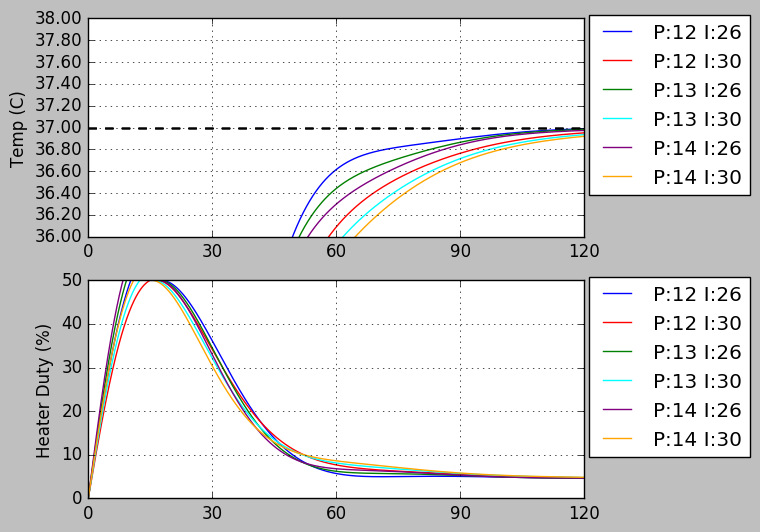

In [16]:
plt.close()
setup3(False)

for p in 12, 13, 14:
    for i in 26, 30:
        ops.pid.p = p
        ops.pid.i = i
        ops.g_mult = 1.3
        ops.k_mult = 0.5
        ops.initial_pv = 23.6
        ops.delay = 20*minutes
        ops.sink_decay = 0.3
        ops.env = 18
        run3(ops, 'P:%d I:%d'%(p, i))
finish3()
ax1.set_ylim(36, 38)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
    #ax1.set_ylim(23, 25)
    #ax1.set_xlim(0, 10)
fig

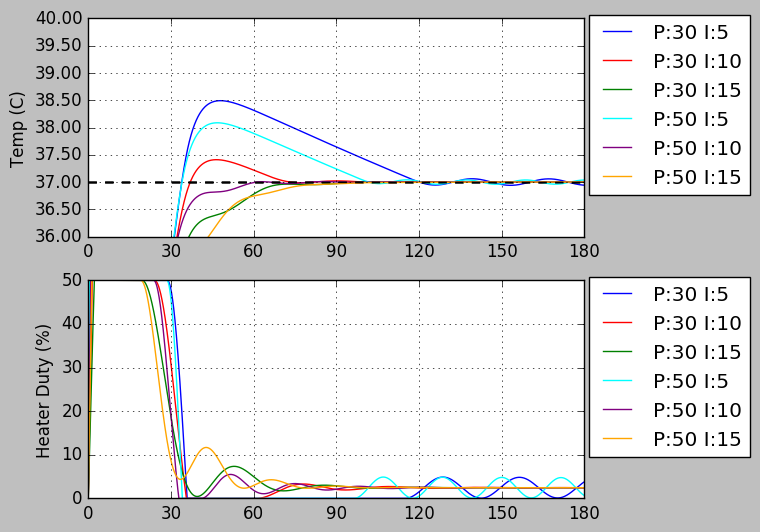

In [23]:
plt.close()
setup3(False)

ops.end = 180*minutes
ops.g_mult = 1.4*2.5/3
ops.k_mult = 0.5*2.5/3
ops.initial_pv = 25.2
ops.delay = 18*minutes
ops.sink_decay = 0.2
ops.env = 25

for p in 30,50:
    for i in 5, 10,15:
        ops.pid.p = p
        ops.pid.i = i
        run3(ops, 'P:%d I:%d'%(p, i))

finish3()

#ax1.yaxis.set_major_locator(MultipleLocator(0.2))
_, m = ax1.get_ylim()
ax1.set_ylim(36, m)
    #ax1.set_xlim(0, 10)
fig

Test finished, inlining plot...


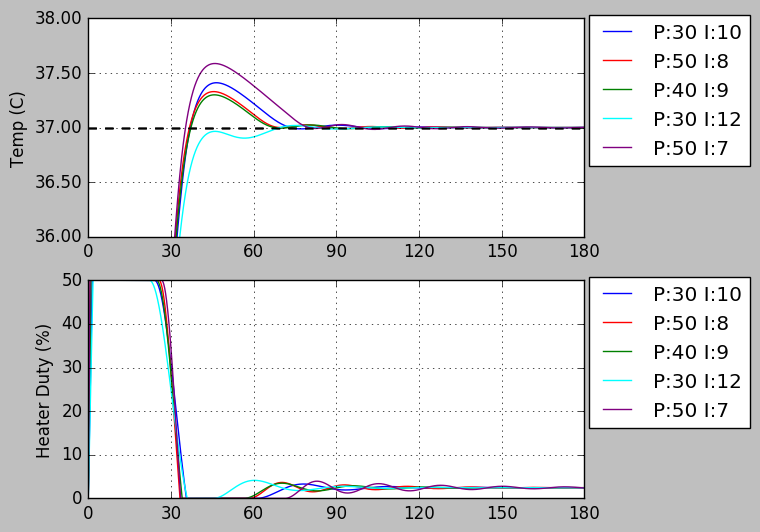

In [28]:
plt.close()
setup3(False)

ops.end = 180*minutes
ops.g_mult = 1.4*2.5/3
ops.k_mult = 0.5*2.5/3
ops.initial_pv = 25.2
ops.delay = 18*minutes
ops.sink_decay = 0.2
ops.env = 25

combos = [
    (30, 10),
    (50, 8),
    (40, 9),
    (30, 12),
    (50, 7)
]
for p, i in combos:
    ops.pid.p = p
    ops.pid.i = i
    run3(ops, 'P:%d I:%d'%(p, i))

finish3()

#ax1.yaxis.set_major_locator(MultipleLocator(0.2))
_, m = ax1.get_ylim()
ax1.set_ylim(36, m)
    #ax1.set_xlim(0, 10)
print("Test finished, inlining plot...")
fig

### Disturbance Rejection

In [143]:
def temp_sim2(ops):
    global sim
    sim = TempSim(ops, 362*minutes)
    sim.sim_iters(180*minutes)
    heat = 1
    for i in range(20*minutes):
        loss = .01 * heat
        heat -= loss
        sim._proc.pv -= loss
        sim.sim_iters(1)
    sim.sim_iters(180*minutes)
    x = sim.get('x')
    pv = sim.get('pv')
    hd = sim.get('hd')
    return x, pv, hd

In [144]:
def run4(ops, lbl):
    global x,pv,hd
    x,pv,hd = temp_sim2(ops)
    plot3(x,pv,hd,lbl)

In [145]:
def _spid(p=None,i=None,d=None):
    if p is not None: ops.pid.p = p
    if i is not None: ops.pid.i = i
    if d is not None: ops.pid.d = d
    return 'P:%d I:%d D:%d'%(ops.pid.p, ops.pid.i, ops.pid.d)

In [149]:
setup3()

ops.end = 180*minutes
ops.g_mult = 1.4
ops.k_mult = 0.5
ops.initial_pv = 37
ops.delay = 18*minutes
ops.sink_decay = 0.2
ops.env = 25
ops.initial_output = 2.461472
ops.mode = 'm2a'

for d in 0, -5, -7,-10:
    s = _spid(50, 20, d)
    run4(ops, s)   

for a in axes():
    a.set_xlim(170, 300)
finish3()

5.784069691292625e-06
5.784069691292625e-06
5.784069691292625e-06
5.784069691292625e-06
